In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import csv
import os

In [2]:
# Initialize Mediapipe Holistic model
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# Colors for drawing
color_face = mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1)
color_face_connection = mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
color_hand = mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4)
color_pose = mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2)


# Desired display size
display_width, display_height = 800, 800

In [34]:
def capture_video():
    cap = cv2.VideoCapture(0)
    results_list = []

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Process the image and detect landmarks
            result = holistic.process(image_rgb)

            # Store the results
            results_list.append(result)

            # Convert the RGB image back to BGR for rendering using OpenCV
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
            #image.flags.writable = True  # Make the image writable again

            # Draw the landmarks
            mp_drawing.draw_landmarks(image_bgr, result.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                      color_face, color_face_connection)
            mp_drawing.draw_landmarks(image_bgr, result.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
            mp_drawing.draw_landmarks(image_bgr, result.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
            mp_drawing.draw_landmarks(image_bgr, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS, color_pose)

            # Resize the image to the desired display size
            image_bgr = cv2.resize(image_bgr, (display_width, display_height))

            # Display the image
            cv2.imshow('Real-Time Object Detection with Landmarks', image_bgr)

            # Check for 'q' key press to exit
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    return results_list

In [35]:
results_list = capture_video()

# Capture landmarks and export to CSV

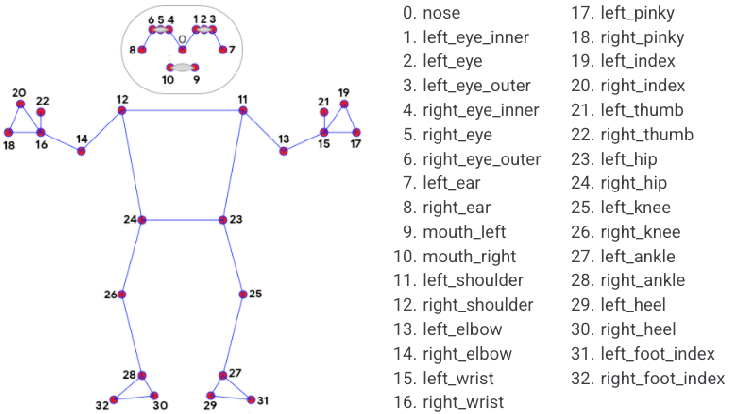

* The collected values from `capture_video` are landmark values stored in `results_list`.
* They are represented 3D coordinates (x,y,z) along with a visibility value for each frame.
* `results_list` consist of face, pose, and hands landmarks.
* Now we want to extract the all the landmarks and append them in a csv dataframe.

In [39]:
# Check the extracted results
results_list[0].pose_landmarks.landmark

[x: 0.523765087
y: 0.306556225
z: -0.494870573
visibility: 0.999976397
, x: 0.541998208
y: 0.267516404
z: -0.473543733
visibility: 0.999946
, x: 0.553687751
y: 0.26743862
z: -0.473307073
visibility: 0.999952316
, x: 0.564484894
y: 0.267965734
z: -0.473225176
visibility: 0.999934554
, x: 0.500860095
y: 0.268617928
z: -0.457633018
visibility: 0.999955297
, x: 0.4868249
y: 0.269928157
z: -0.457662523
visibility: 0.999960899
, x: 0.474266469
y: 0.271905243
z: -0.45770365
visibility: 0.999952555
, x: 0.582443953
y: 0.28223297
z: -0.280662417
visibility: 0.999969721
, x: 0.462919056
y: 0.289497256
z: -0.201472834
visibility: 0.999974728
, x: 0.545601368
y: 0.350335062
z: -0.421346724
visibility: 0.999989152
, x: 0.502782762
y: 0.356490612
z: -0.399794281
visibility: 0.999989748
, x: 0.67873168
y: 0.505387545
z: -0.167392224
visibility: 0.999961138
, x: 0.397347808
y: 0.504985332
z: -0.0111364704
visibility: 0.99998486
, x: 0.796482503
y: 0.82363534
z: -0.396454275
visibility: 0.998288333
, x

# Creating the CSV file

In [42]:
# Initialize headers for the CSV file
landmarks = ['class']
num_coords = 0
if results_list[0].pose_landmarks:
    num_coords += len(results_list[0].pose_landmarks.landmark)
if results_list[0].face_landmarks:
    num_coords += len(results_list[0].face_landmarks.landmark)

# Can add other if statements to add the coordinates of the hands

for val in range(1, num_coords + 1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

num_coords

501

In [41]:
# Write the headers to the CSV file
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

# Recreate the capture function but with pose and face landmarks extraction

In [43]:
# This cell is for data collection
def collect_dataset(class_name: str):
    cap = cv2.VideoCapture(0)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Process the image and detect landmarks
            result = holistic.process(image_rgb)

            try:
                # Extract Pose Landmarks
                pose = result.pose_landmarks.landmark
                pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

                # Extract Face Landmarks
                face = result.face_landmarks.landmark
                face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

                # Combine Pose and Face Landmarks
                row = pose_row + face_row
                row.insert(0, class_name)

                # Write the landmarks to the CSV file
                with open('coords.csv', mode='a', newline='') as f:
                    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)

            except:
                pass

            # Convert the RGB image back to BGR for rendering using OpenCV
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
            # Draw the landmarks
            mp_drawing.draw_landmarks(image_bgr, result.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
            mp_drawing.draw_landmarks(image_bgr, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

            # Display the image
            cv2.imshow('Real-Time Object Detection with Landmarks', image_bgr)

            # Check for 'q' key press to exit
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [46]:
# Call the capture function with the class name
collect_dataset('Victory')

* Now the collection of the dataset has finished, check `coords.csv` to see the data.?

# Training the model using Sklearn

In [3]:
# Import the main libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pickle

In [4]:
# Define the data frame
df = pd.read_csv('coords.csv')
X = df.drop('class', axis=1)
y = df['class']

In [5]:
# Explore the data
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
0,Happy,0.499203,0.269148,-1.195772,0.999948,0.527782,0.194392,-1.160664,0.999819,0.544697,...,-0.005584,0.0,0.560181,0.200617,0.012693,0.0,0.564703,0.195009,0.013189,0.0
1,Happy,0.498160,0.269286,-0.995104,0.999947,0.527188,0.196366,-0.965213,0.999805,0.544000,...,-0.007315,0.0,0.554021,0.200271,0.008626,0.0,0.558604,0.194961,0.008873,0.0
2,Happy,0.497288,0.269447,-0.966112,0.999944,0.526499,0.198767,-0.938669,0.999783,0.543356,...,-0.006782,0.0,0.553404,0.200100,0.009938,0.0,0.557979,0.194371,0.010315,0.0
3,Happy,0.496182,0.269667,-0.868597,0.999943,0.525766,0.200808,-0.844090,0.999777,0.542670,...,-0.006590,0.0,0.553197,0.199621,0.010249,0.0,0.557696,0.194111,0.010637,0.0
4,Happy,0.496240,0.270707,-0.850805,0.999945,0.525811,0.203368,-0.823993,0.999782,0.542813,...,-0.006066,0.0,0.553844,0.200606,0.010906,0.0,0.558532,0.194520,0.011447,0.0


In [6]:
df.tail()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
379,Victory,0.425056,0.301473,-0.308076,0.999734,0.445124,0.255677,-0.275247,0.999613,0.459826,...,-0.008480,0.0,0.477739,0.244723,-0.005199,0.0,0.481253,0.241318,-0.005706,0.0
380,Victory,0.433846,0.270186,-0.434111,0.999601,0.455255,0.225244,-0.392771,0.999381,0.470282,...,-0.008573,0.0,0.484715,0.222291,-0.007919,0.0,0.488730,0.218609,-0.008665,0.0
381,Victory,0.457340,0.272121,-0.526080,0.999515,0.480757,0.221601,-0.480095,0.999205,0.497940,...,-0.013260,0.0,0.513916,0.221030,-0.006789,0.0,0.517779,0.216462,-0.007061,0.0
382,Victory,0.490463,0.274138,-0.647173,0.999164,0.510718,0.218647,-0.593315,0.998849,0.527357,...,-0.010818,0.0,0.542497,0.215971,0.004778,0.0,0.546128,0.211366,0.005238,0.0
383,Victory,0.496926,0.274807,-0.788870,0.998708,0.515761,0.217083,-0.742046,0.997870,0.531164,...,-0.010854,0.0,0.546839,0.214509,0.005908,0.0,0.550430,0.209596,0.006447,0.0


In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression()), # has predict_proba()
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()), # has predict_proba()
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [9]:
list(pipelines.values())[0]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [10]:
# Train the model
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [11]:
# Make some predictions
fit_models['rc'].predict(X_test)

array(['Victory', 'Victory', 'Victory', 'Victory', 'Happy', 'Victory',
       'Happy', 'Sad', 'Victory', 'Sad', 'Sad', 'Sad', 'Sad', 'Victory',
       'Happy', 'Sad', 'Sad', 'Victory', 'Victory', 'Sad', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Victory',
       'Happy', 'Victory', 'Happy', 'Happy', 'Victory', 'Happy', 'Sad',
       'Victory', 'Sad', 'Happy', 'Victory', 'Victory', 'Happy', 'Sad',
       'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Victory', 'Sad', 'Sad', 'Victory', 'Sad',
       'Happy', 'Happy', 'Sad', 'Happy', 'Victory', 'Happy', 'Victory',
       'Sad', 'Sad', 'Victory', 'Sad', 'Victory', 'Happy', 'Happy', 'Sad',
       'Happy', 'Sad', 'Happy', 'Sad', 'Happy'], dtype='<U7')

## Evaluate the model

In [12]:
# Check the best performing model to export
for algo, model in fit_models.items():
    y_hat = model.predict(X_test)
    print(algo, accuracy_score(y_test, y_hat))

lr 1.0
rc 1.0
rf 1.0
gb 1.0


In [13]:
# Make some predictions using a specified model
fit_models['rf'].predict(X_test)

array(['Victory', 'Victory', 'Victory', 'Victory', 'Happy', 'Victory',
       'Happy', 'Sad', 'Victory', 'Sad', 'Sad', 'Sad', 'Sad', 'Victory',
       'Happy', 'Sad', 'Sad', 'Victory', 'Victory', 'Sad', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Victory',
       'Happy', 'Victory', 'Happy', 'Happy', 'Victory', 'Happy', 'Sad',
       'Victory', 'Sad', 'Happy', 'Victory', 'Victory', 'Happy', 'Sad',
       'Sad', 'Sad', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Victory', 'Sad', 'Sad', 'Victory', 'Sad',
       'Happy', 'Happy', 'Sad', 'Happy', 'Victory', 'Happy', 'Victory',
       'Sad', 'Sad', 'Victory', 'Sad', 'Victory', 'Happy', 'Happy', 'Sad',
       'Happy', 'Sad', 'Happy', 'Sad', 'Happy'], dtype=object)

In [17]:
import pickle

# Create the pickle file to store the desired model
with open('body_language.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f) 

# Make detections with Model

In [57]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='google.protobuf.symbol_database')

In [18]:
# Load the model
with open('body_language.pkl', 'rb') as f:
    model = pickle.load(f)

In [54]:
# Read feature names from coords.csv
with open('coords.csv', mode='r', newline='') as f:
    reader = csv.reader(f)
    feature_names = next(reader)

# Remove the 'class' column from feature names if present
if 'class' in feature_names:
    feature_names.remove('class')

In [62]:
def draw_text_with_background(image, text, position, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, font_thickness=2, text_color=(0, 0, 255), bg_color=(0, 0, 0)):
    # Calculate text size
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size

    # Set the rectangle coordinates
    rect_x1 = position[0] - 5
    rect_y1 = position[1] - text_h - 5
    rect_x2 = position[0] + text_w + 5
    rect_y2 = position[1] + 5

    # Draw the rectangle
    cv2.rectangle(image, (rect_x1, rect_y1), (rect_x2, rect_y2), bg_color, -1)

    # Put the text inside the rectangle
    cv2.putText(image, text, position, font, font_scale, text_color, font_thickness)


# This cell is for data collection
def make_detection():
    cap = cv2.VideoCapture(0)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Convert the RGB image back to BGR for rendering using OpenCV
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
            
            # Process the image and detect landmarks
            result = holistic.process(image_rgb)

            try:
                # Extract Pose Landmarks
                pose = result.pose_landmarks.landmark if result.pose_landmarks else []
                pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

                # Extract Face Landmarks
                face = result.face_landmarks.landmark if result.face_landmarks else []
                face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

                # Combine Pose and Face Landmarks
                row = pose_row + face_row

                # Make detections
                X = pd.DataFrame([row], columns=feature_names)
                body_language_class = model.predict(X)[0]
                body_language_prob = model.predict_proba(X)[0]

                # Render the class and probability on the image
                draw_text_with_background(image_bgr, f'Class: {body_language_class}', (10, 30))
                draw_text_with_background(image_bgr, f'Prob: {body_language_prob[np.argmax(body_language_prob)]:.2f}', (10, 60))

            except Exception as e:
                print(f"Error processing frame: {e}")
                pass

            # Draw the landmarks
            mp_drawing.draw_landmarks(image_bgr, result.face_landmarks, mp_holistic.FACEMESH_CONTOURS, color_face, color_face_connection)
            mp_drawing.draw_landmarks(image_bgr, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
            mp_drawing.draw_landmarks(image_bgr, result.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
            mp_drawing.draw_landmarks(image_bgr, result.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)

            # Display the image
            cv2.imshow('Real-Time Object Detection with Landmarks', image_bgr)

            # Check for 'q' key press to exit
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [63]:
make_detection()